<h1><font size = "+6"> <b>House Price Predictor</b></font></h1>

Author : Amogh Pradeep<br>Email : amogh.pradeep049@nmims.edu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import math
sns.set()
# plt.style.use("dark_background")
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv("house-prices-advanced-regression-techniques\\train.csv")

In [4]:
test_df = pd.read_csv("house-prices-advanced-regression-techniques\\test.csv")

##### Pre-defined function template
Ignore below code cell !

In [5]:
# Helper Functions -- Jump to code cell below
def get_scatterplot(var, col = 10, row = 7):
    plt.figure(figsize=(col, row))
    data = pd.concat([df[var], df[target]], axis = 1)
    sns.scatterplot(data = data, x = var, y = target)

def get_boxplot(x, y = None, col = 10, row = 7):
    plt.figure(figsize=(col, row))
    data = pd.concat([df[x], df[target]], axis = 1)
    if y == None:
        sns.boxplot(data = data, x = x)
    else:
        sns.boxplot(data = data, x = x, y = y)

def get_heatmap(correlations, theme = "bwr", col = 15, row = 15, round_off = 1, annot = False):
    plt.figure(figsize=(col, row))
    round_off = str(round_off)
    sns.heatmap(correlations, square = True, cmap = theme, fmt = "." + round_off + "f", annot = annot, center = 0, linecolor ="white")

def get_correlated(k = 10, plot = True, theme = "bwr", col = 15, row = 15, round_off = 1, annot = False):
    cols = df.corr().nlargest(k, target)[target]
    if plot:
        get_heatmap(df[cols.index].corr(), theme, col, row, round_off, annot)
    return cols

def get_pairplot(vars, col = 15, row = 15, size = 2.5):
    plt.figure(figsize=(col, row))
    sns.pairplot(df[vars], size = size)

# Set kde = False to disable line.
def get_distplot(var, kde = True, fit = None):
    sns.distplot(df[var], kde = kde, fit = fit)
    return {"Skewness" : df[var].skew(), "Kurtosis" : df[var].kurt()}

# Returns categorical cols, numeric cols, and labelled dataframe consisting of both.
def identify_columns():
    categorical = [col for col in df.columns if df[col].dtype == 'O']
    numeric = [col for col in df.columns if df[col].dtype != 'O']
    data = pd.concat([pd.Series(categorical, name="categorical"), pd.Series(numeric, name = "numeric")], axis=1)
    return categorical, numeric, data


# Returns boolean (whether condition exists), chi square statistic, p-value, critical value.
def chi_square(col1, col2):
    table = pd.crosstab(index = col1, columns=col2)
    expected_values = stats.chi2_contingency(table)[3]

    x = len(table)
    y = len(table.columns)
    degrees = (x - 1) * (y - 1)
    alpha = 0.05

    chi_square = sum([(o - e) ** 2 / e for o, e in zip(table.values, expected_values)])
    chi_square_statistic = sum(chi_square)

    critical_value = stats.chi2.ppf(q = 1 - alpha, df = degrees)

    p_value = 1 - stats.chi2.cdf(x = chi_square_statistic, df = degrees)

    condition1 = False
    condition2 = False
    if chi_square_statistic>=critical_value:
        condition1 = True
    if p_value<=alpha:
        condition2 = True

    return condition1 & condition2, chi_square_statistic, p_value, critical_value

### Initial Dataset Analysis

In [6]:
df.columns.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

In [7]:
df.shape, test_df.shape

((1460, 81), (1459, 80))

In [8]:
categorical, numeric, column_data = identify_columns()
column_data

,categorical,numeric
0,MSZoning,Id
1,Street,MSSubClass
2,Alley,LotFrontage
3,LotShape,LotArea
4,LandContour,OverallQual
5,Utilities,OverallCond
6,LotConfig,YearBuilt
7,LandSlope,YearRemodAdd
8,Neighborhood,MasVnrArea
9,Condition1,BsmtFinSF1


# Exploratory Data Analysis

## Analyzing Sales Price - target variable

In [9]:
target = "SalePrice"
df[target].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### 1. Examining Relationships with SalePrice

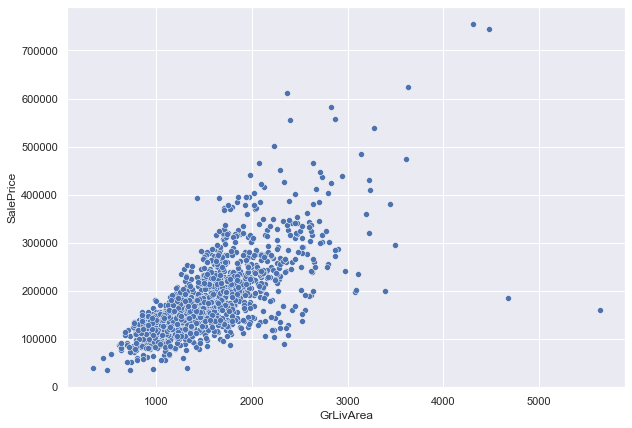

In [10]:
#GrLivArea
get_scatterplot("GrLivArea")

2 Outliers present!

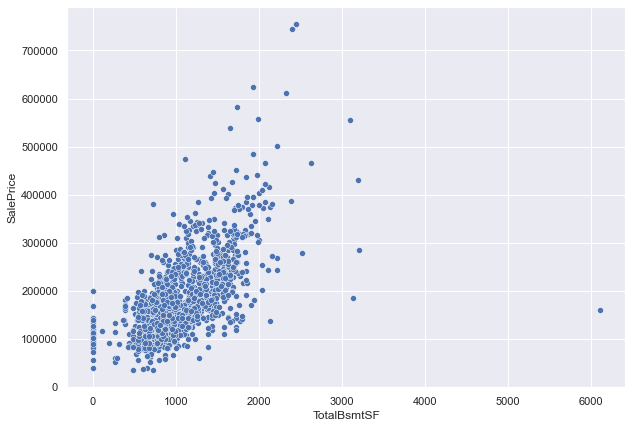

In [11]:
# TotalBsmtSF
get_scatterplot("TotalBsmtSF")

1 Outlier present.

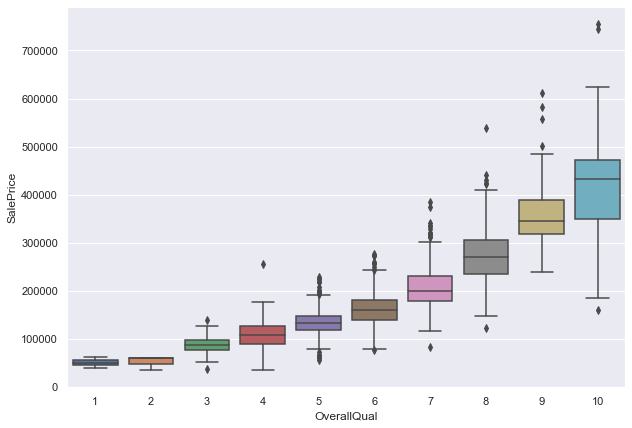

In [12]:
get_boxplot(x = "OverallQual", y = target)

A distinct upward trend in SalePrice is observed as expected.

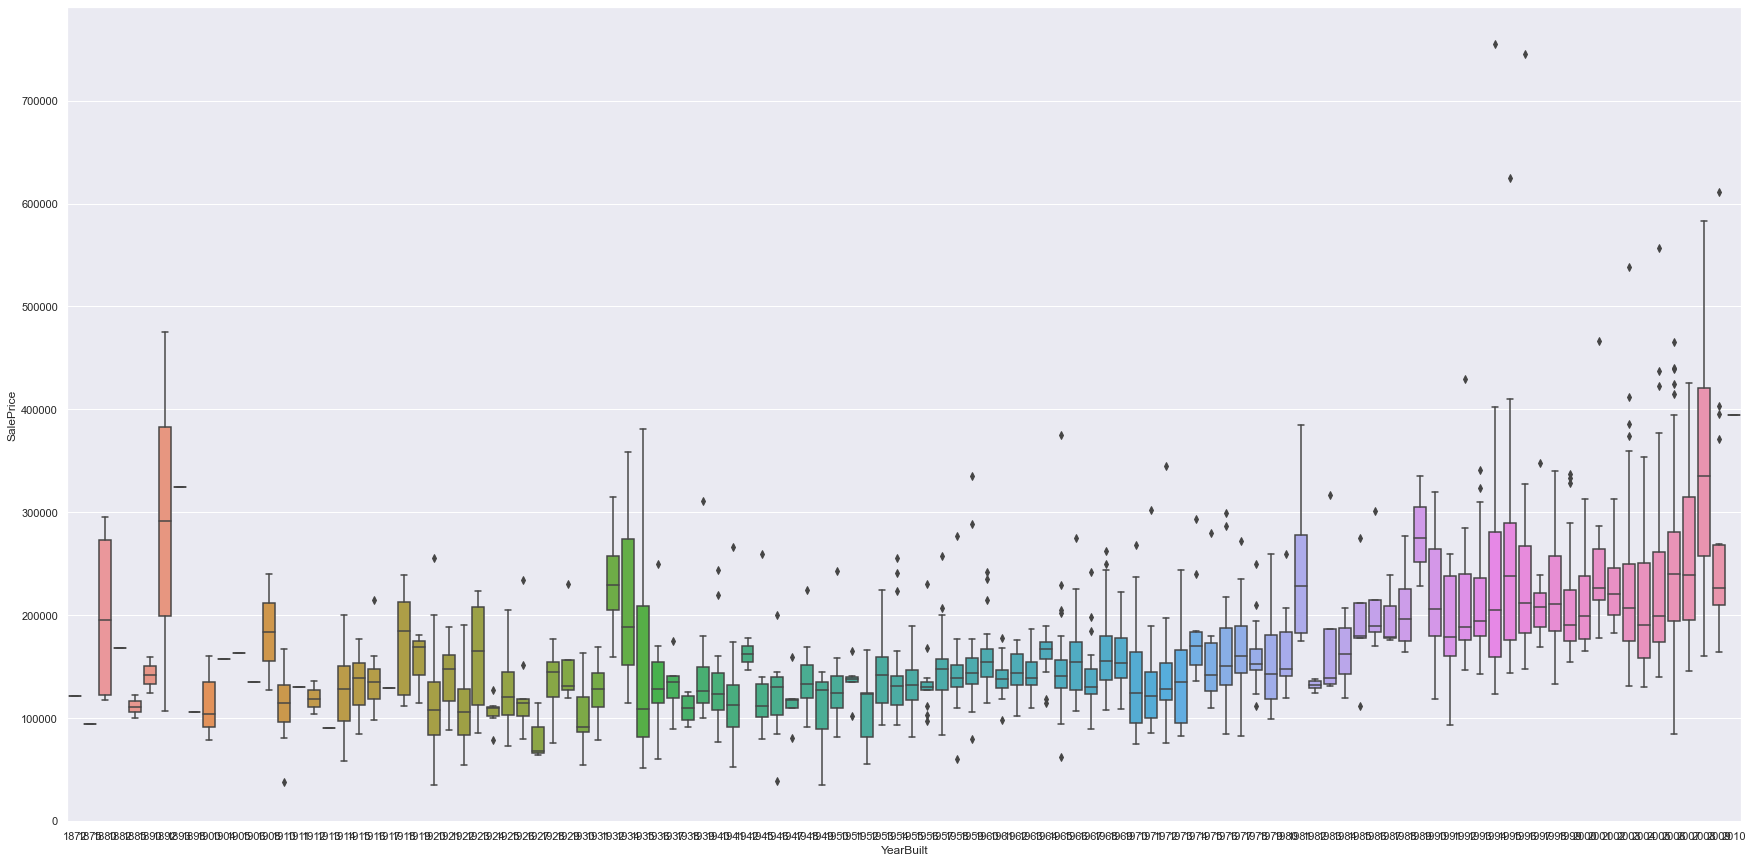

In [13]:
get_boxplot(x = "YearBuilt", y = target, col=30, row=15)

No distinct long-term trend can be seen, though there is a recent uptick in house prices.

## Discrete Variable Heatmap analysis

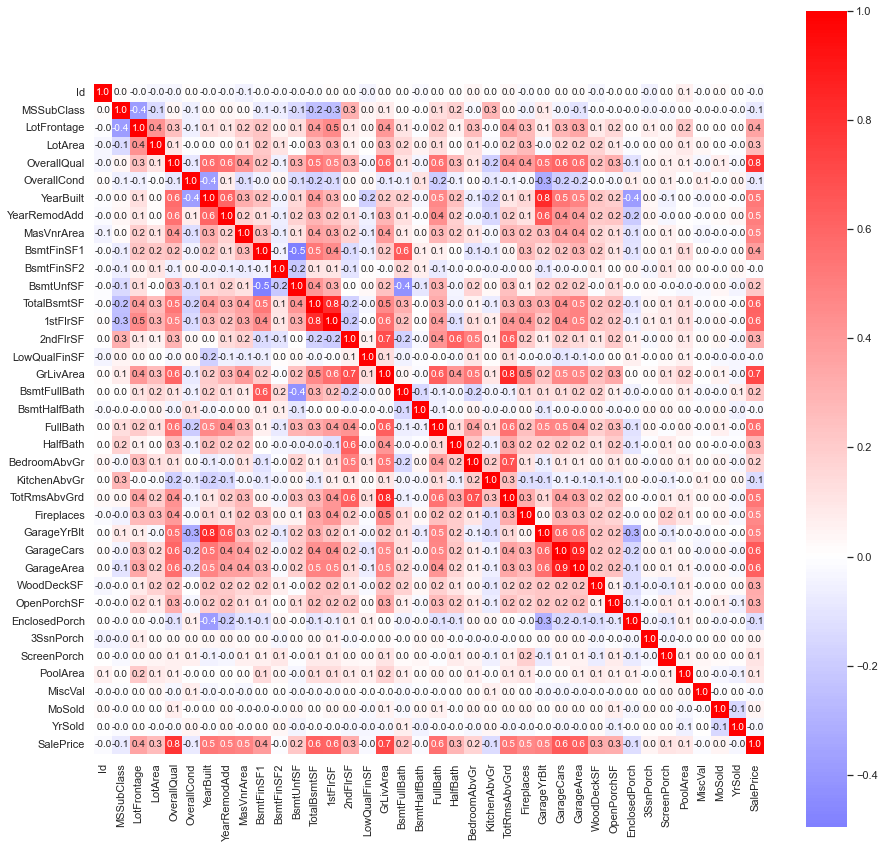

In [14]:
get_heatmap(df.corr(), annot=True)

Text(0.5, 1.0, 'Top 10 correlated features w/ SalePrice\n')

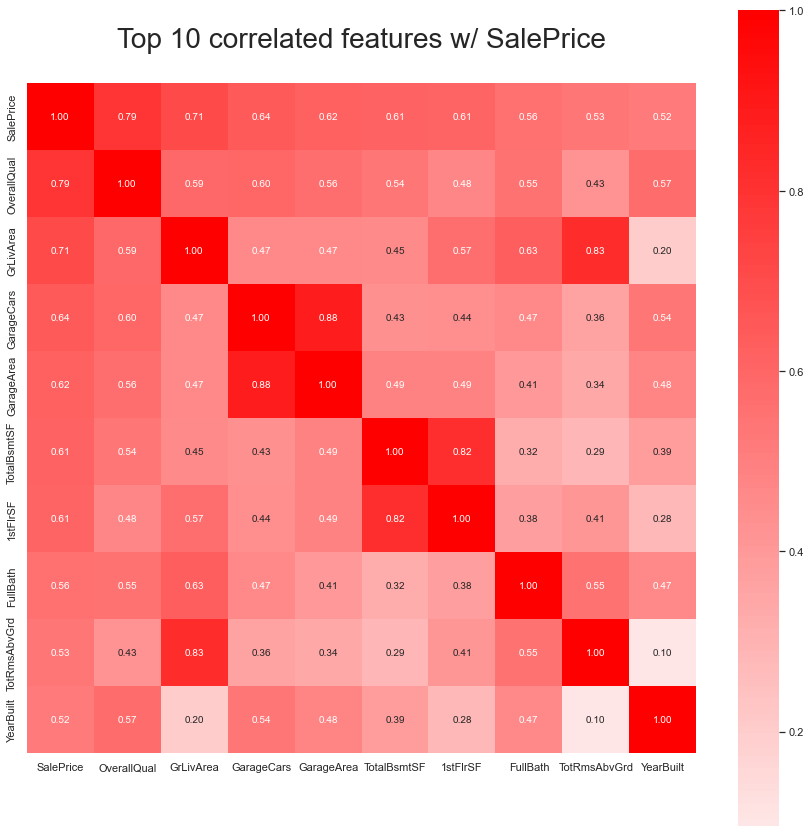

In [15]:
discrete_high_corr = get_correlated(annot=True, round_off=2)
plt.title("Top 10 correlated features w/ SalePrice\n", fontsize = 28)

#### Distribution of top correlated features

<Figure size 1080x1080 with 0 Axes>

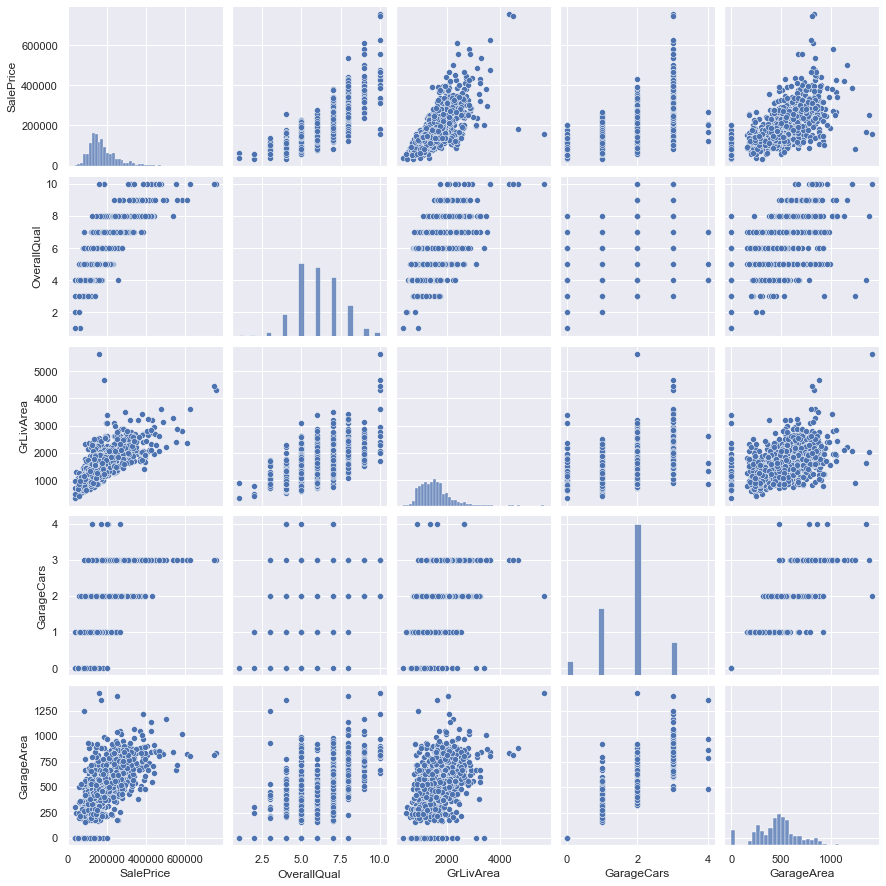

In [16]:
get_pairplot(discrete_high_corr.index.tolist()[: 5])

## Missing Data

#### Combining Test and Train Dataset.
This will help deal with missing data efficiently, in both test and train data.

In [17]:
# Combining Both the dataframes, as any transformation we apply (on non-target columns)
# must be applied to both train and test.
ntrain = df.shape[0]
ntest = test_df.shape[0]
y_train = df["SalePrice"]
df.drop(columns = "SalePrice", inplace = True)
df = pd.concat([df, test_df])
print("Combined Dimensions are {}".format(df.shape))
print("y_train dimensions are {}".format(y_train.shape))

Combined Dimensions are (2919, 80)
y_train dimensions are (1460,)


In [18]:
# Let's check how bad it is...
total = df.isnull().sum().sort_values(ascending=False)
percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) * 100

missing_data = pd.concat([total, percentage], axis=1, keys=["Total", "% Missing"])
missing_data.head(20)

,Total,% Missing
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


<hr> Step 1 : Data description says that with these columns "na" actually means that the given feature is not present in the house. <br>
This means that the data is not missing, the feature is.

In [19]:
# replacing na with appropriate values where na doesn't mean "data not available"
df["PoolQC"] = df["PoolQC"].fillna("None") # na means no pool
df["MiscFeature"] = df["MiscFeature"].fillna("None") # na means no misc feature
df["Alley"] = df["Alley"].fillna("None") # na means no misc feature
df["Fence"] = df["Fence"].fillna("None") # na means no fence
df["FireplaceQu"] = df["FireplaceQu"].fillna("None") # na means no fireplace

Step 2 : Dealing with all garage features.

In [20]:
# replacing values for homes without garages.
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

Step 3 : Dealing with all basement features.

In [21]:
# replacing values for homes without basements.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

In [22]:
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

Step 4 : Replacing discrete values with median.<br> **Note** : By replacing with median of the entire dataset (test + train), data leakage occurs. But that is ultimately better for accuracy in competition.

In [23]:
missing_data = [var for var in df.columns if df[var].isnull().sum() > 0]
for var in missing_data:
    if df[var].dtype == 'O':
        df[var] = df[var].fillna(df[var].mode()[0])
    else:
        df[var] = df[var].fillna(df[var].mode()[0])

In [24]:
df.isnull().sum().max()

0

## Outliers
Let's get rid of outliers we saw earlier.

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

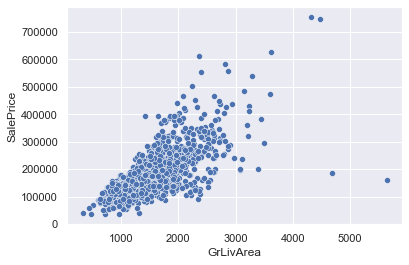

In [25]:
# Let's check GrLivArea
GrLivArea = df.iloc[ : ntrain, df.columns.get_loc("GrLivArea")]
sns.scatterplot(data = pd.concat([GrLivArea, y_train], axis = 1), x = "GrLivArea", y = target)

Outliers Present

In [26]:
df.drop(index = df[df["GrLivArea"] > 4790].index, inplace = True)
df.shape

(2915, 80)

In [27]:
df.drop(columns = "Id", inplace = True)

These are actually categorical classes but disguised as discrete numbers. Let’s first convert them into categorical values, and then use LabelEncoder on them to prevent an inconsistencies.

In [28]:
not_discrete = []
for feature in df.columns:
    if len(df[feature].unique()) < 20 and df[feature].dtype != "object":
        df[feature] = df[feature].astype(str)
        not_discrete.append(feature)

## Normalizing Variables

In [29]:
# Let's find the skew for all the numerical features.
numeric = [var for var in df.columns if df[var].dtype != "object"]
skewed = [df[var].skew() for var in numeric]
skewed = pd.Series(skewed, index=numeric, name="Skew").sort_values(ascending=False)
skewed

MiscVal          22.187088
LotArea          13.112975
LowQualFinSF     12.086535
3SsnPorch        11.373947
BsmtFinSF2        4.144996
EnclosedPorch     4.016257
ScreenPorch       3.945539
MasVnrArea        2.590666
OpenPorchSF       2.507524
WoodDeckSF        1.843429
LotFrontage       1.385772
GrLivArea         1.035419
1stFlrSF          0.982260
BsmtUnfSF         0.919597
2ndFlrSF          0.863401
BsmtFinSF1        0.852159
TotalBsmtSF       0.443876
GarageArea        0.210961
YearRemodAdd     -0.450595
YearBuilt        -0.599821
GarageYrBlt      -3.905059
Name: Skew, dtype: float64

In [30]:
# Filtering out variables whose skew is greater than 0.75 (abs)
for (skew, index) in zip(skewed, skewed.index):
    if skew < 0.75:
        skewed.drop(index = index, inplace = True)
skewed

MiscVal          22.187088
LotArea          13.112975
LowQualFinSF     12.086535
3SsnPorch        11.373947
BsmtFinSF2        4.144996
EnclosedPorch     4.016257
ScreenPorch       3.945539
MasVnrArea        2.590666
OpenPorchSF       2.507524
WoodDeckSF        1.843429
LotFrontage       1.385772
GrLivArea         1.035419
1stFlrSF          0.982260
BsmtUnfSF         0.919597
2ndFlrSF          0.863401
BsmtFinSF1        0.852159
Name: Skew, dtype: float64

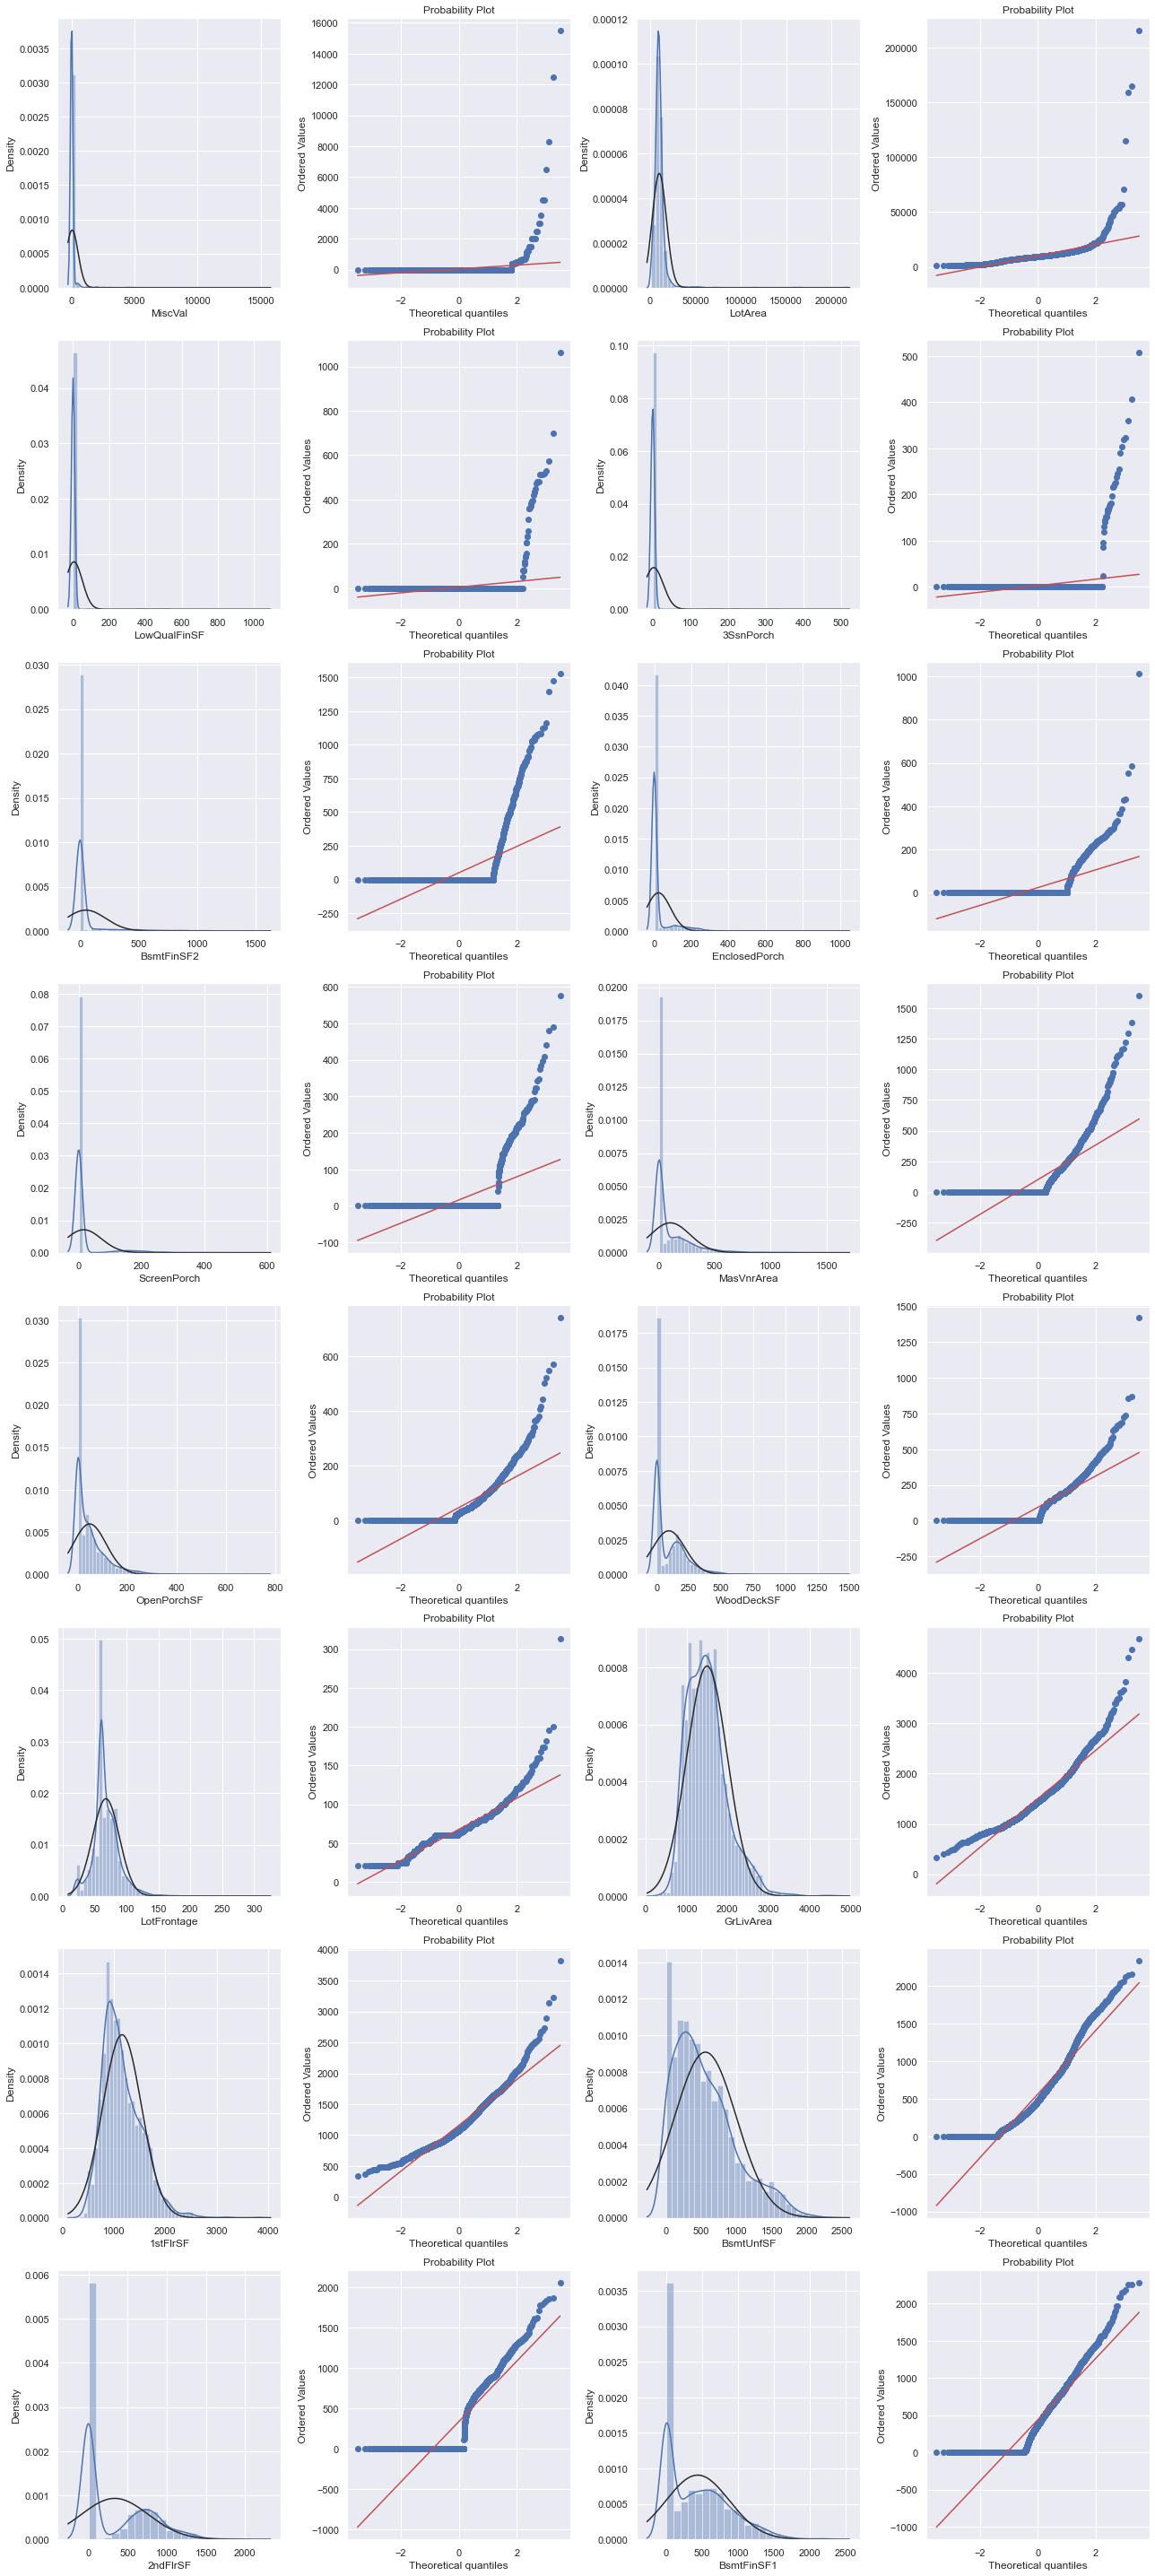

In [31]:
# Visualizing distribution.
plot_no = 0
plt.figure(figsize=(18, 40))
for feature in skewed.index:
    plt.subplot(8, 4, plot_no + 1)
    sns.distplot(df[feature], kde = True, fit=norm)
    plt.subplot(8, 4, plot_no + 2)
    stats.probplot(df[feature], plot=plt)
    plot_no += 2
plt.tight_layout()

Now that we have all the skewed features, I chose to apply log1p transformation.
log1p adds 1 to all values and then applies log. This is to prevent log(0) errors.

In [32]:
# applying log transformation to 1 + x.
df_temp = df.copy()
from scipy.special import boxcox1p
lam = 0.15
for feat in skewed.index:
    df_temp[feat] = boxcox1p(df_temp[feat], lam)

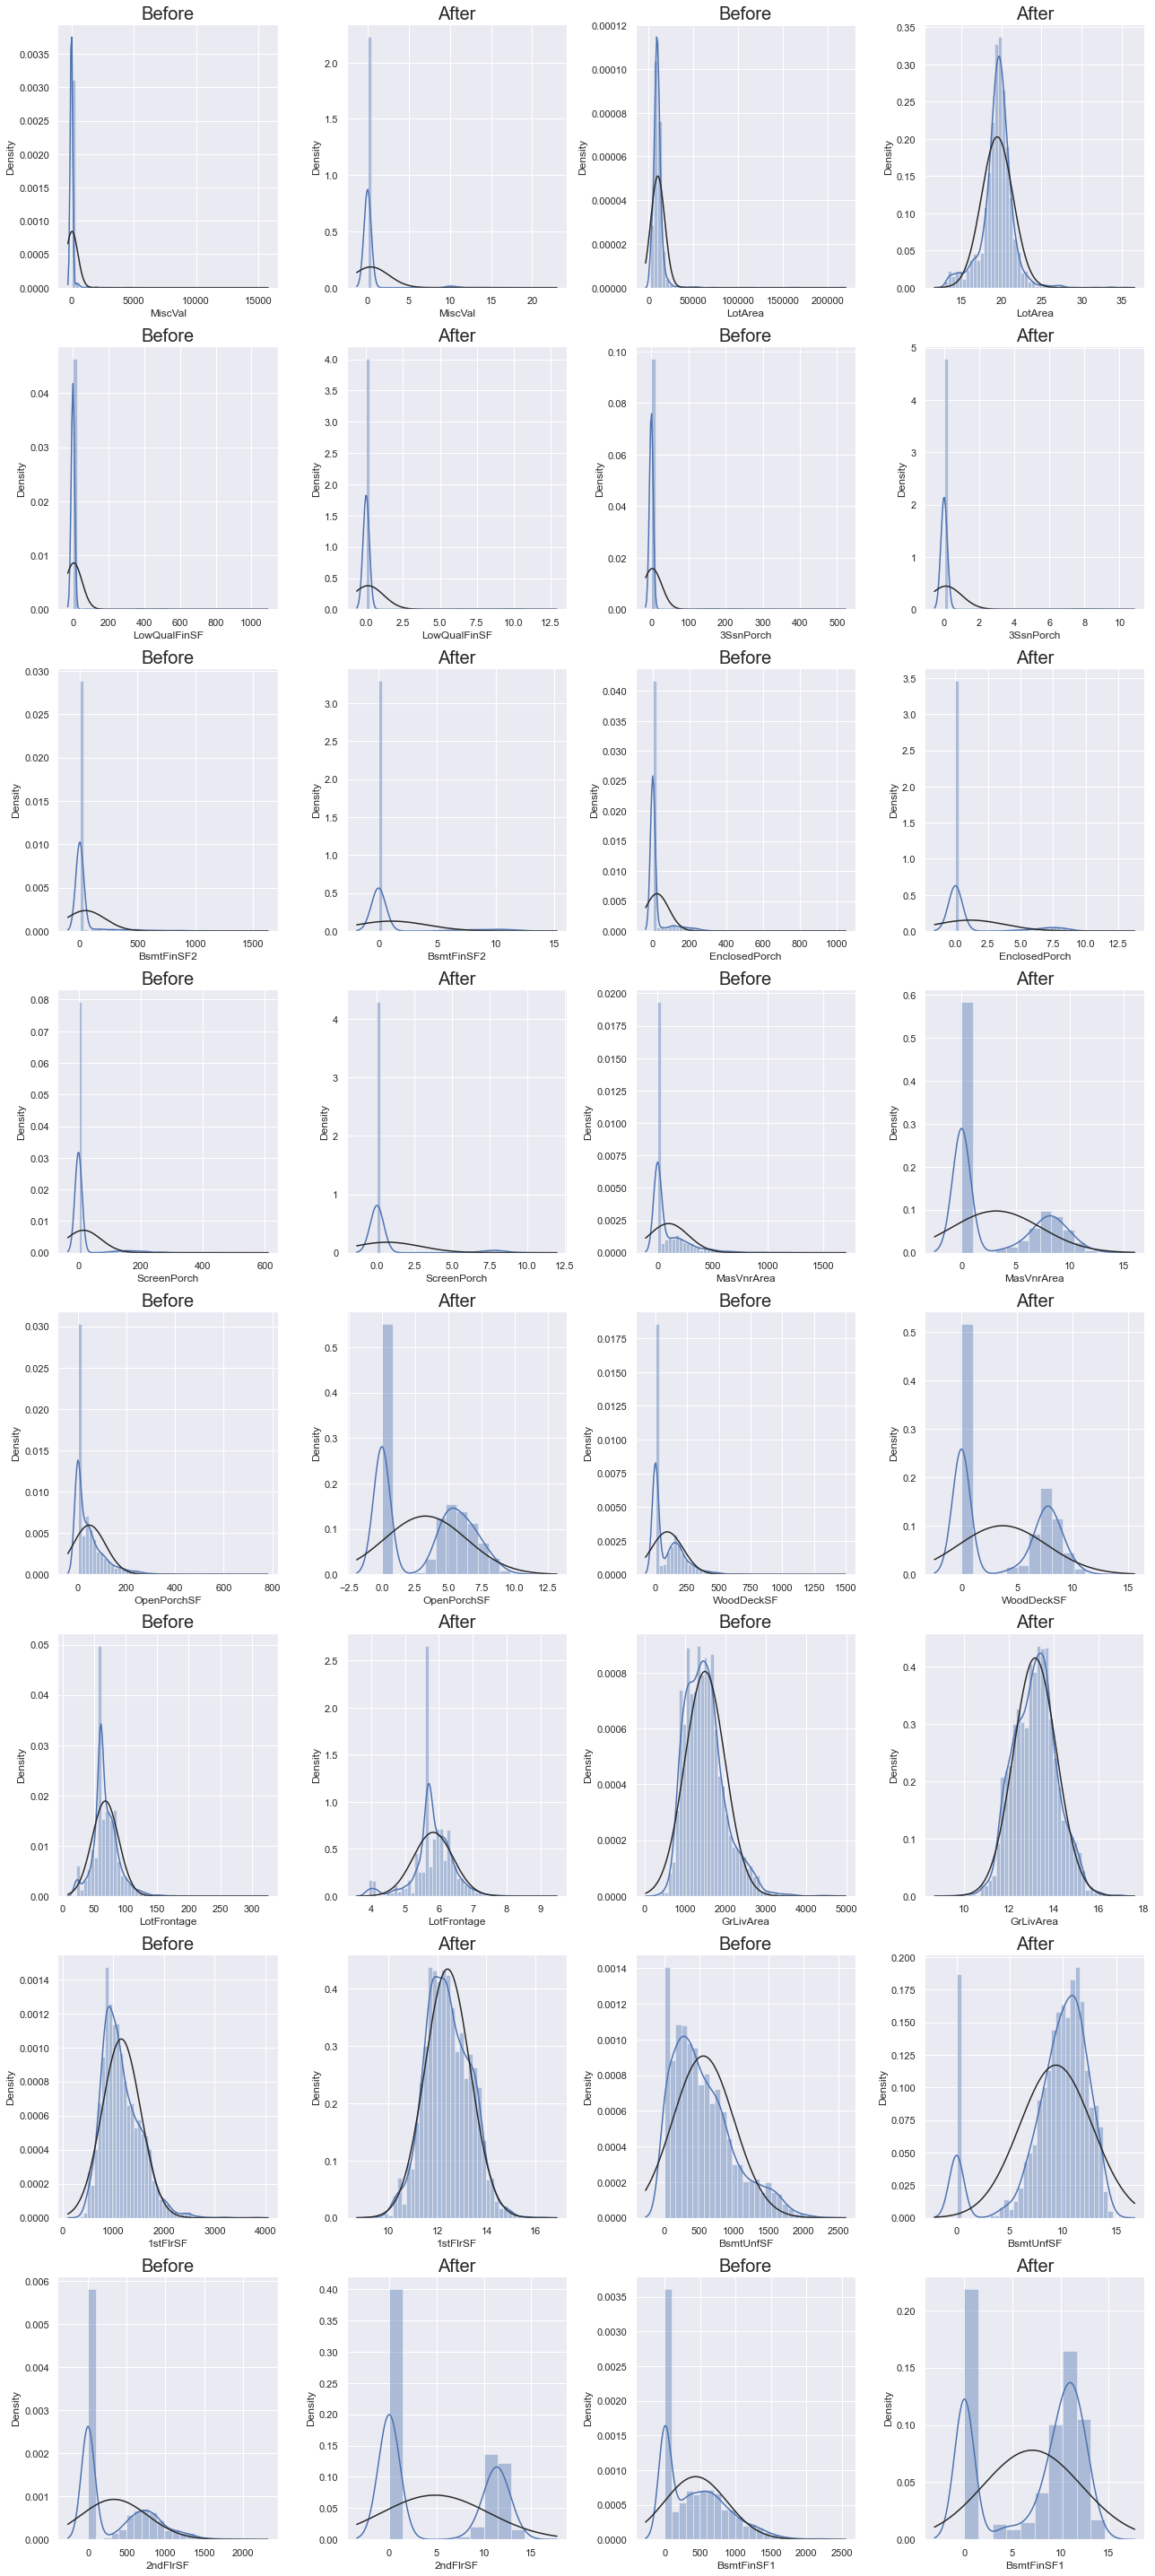

In [33]:
plot_no = 0
plt.figure(figsize=(18, 40))
for feature in skewed.index:
    plt.subplot(8, 4, plot_no + 1)
    sns.distplot(df[feature], kde = True, fit=norm)
    plt.title("Before", fontsize = 20)
    plt.subplot(8, 4, plot_no + 2)
    sns.distplot(df_temp[feature], kde = True, fit=norm)
    plt.title("After", fontsize = 20)
    plot_no += 2

plt.tight_layout()

In [34]:
df = df_temp

## Final Changes

These are actually categorical classes but disguised as discrete numbers.<br> Let's first convert them into categorical values, and then use LabelEncoder on them to prevent an inconsistencies.

In [35]:
tuple(not_discrete)

('MSSubClass',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold',
 'YrSold')

In [36]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
cols = tuple(set(cols + tuple(not_discrete)))

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(df[c].values))
    df[c] = lbl.transform(list(df[c].values))

# shape
print('Shape all_data: {}'.format(df.shape))

Shape all_data: (2915, 79)


In [37]:
# Adding total sq-footage feature
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

### Creating Dummy Variables

In [38]:
df = pd.get_dummies(df)

In [39]:
df.shape

(2915, 222)

In [40]:
train = df[:ntrain]
test = df[ntrain:]
y = y_train

In [41]:
train.shape

(1460, 222)

# Modelling
Let's start with basic models like Linear Regression, SVR etc, then move on to their respective improvements like Lasso Regression and finally to Ensemble Learning.


### <u>Basic Modelling</u>

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state=1)

Pre-defined functions for calculating metrics easily. <br>Ignore below code cell.

In [43]:
# Calculating R2 and Adjusted R2
def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

def adj_rsquared(x, y, p):
    r = rsquared(x, y)
    n = len(x)
    return 1 - (((1 - r) * (n - 1))/(n - p - 1))
# Calculating RMSE
def mse(x, y):
    mse_score = 0
    for actual, pred, in zip(x, y):
        mse_score += (actual - pred) ** 2
    return mse_score / len(x)

# Calculating MAE
def mae(x, y):
    mae_score = 0
    for actual, pred in zip(x, y):
        mae_score += abs(actual - pred)
    return mae_score / len(x)

# Calculating root means squared of log of errors.
def rmsle(x, y):
    rmsle_score = 0
    for actual, pred in zip(x, y):
        rmsle_score += (np.log1p(actual) - np.log1p(pred)) ** 2
    return math.sqrt(rmsle_score / len(x))


In [44]:
model_results = pd.DataFrame(columns=["R2", "Adj-R2", "RMSE", "RMSLE", "MAE"])

### 1. Random Forest Regressor

In [45]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=0)

In [46]:
y_pred = regressor.predict(X_test)

#### Analysing results

In [47]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Random Forest Results\n')

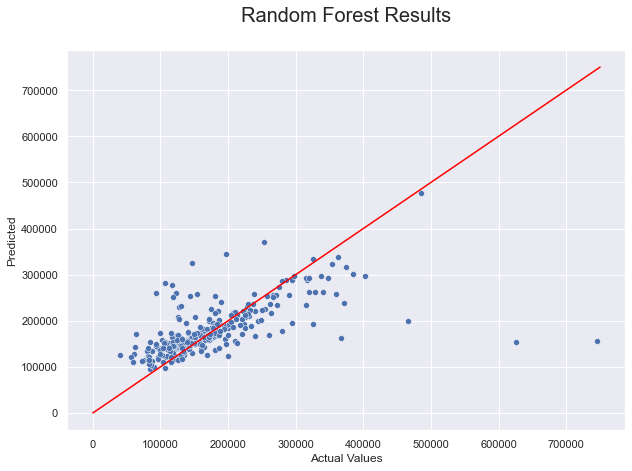

In [48]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000], color = "red")
plt.title("Random Forest Results\n", fontsize = 20)

More <b>distant</b> the points are from the line, more the error.

In [49]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Random Forest"
model_results.index = indexes

In [50]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Random Forest,0.396177,-1.546556,65720.951641,0.305269,35028.155719


### 2. Multiple Linear Regression

In [51]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [52]:
y_pred = lin_reg.predict(X_test)

In [53]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Multiple Linear Regression Results\n')

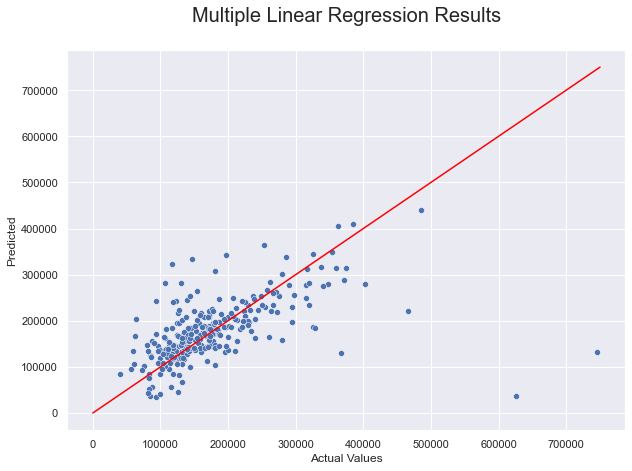

In [54]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("Multiple Linear Regression Results\n", fontsize = 20)

In [55]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Multiple Linear"
model_results.index = indexes

In [56]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Multiple Linear,0.299827,-1.952905,73106.764335,0.378483,41250.383393


### 3. Polynomial Regression

In [57]:
# first we have to raise the matrix of features to different powers.
from sklearn import preprocessing
poly_reg = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
lin_reg2 = linear_model.LinearRegression()
lin_reg2.fit(X_poly, y_train)

LinearRegression()

In [58]:
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_test))

In [59]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Polynomial Linear Regression Results\n')

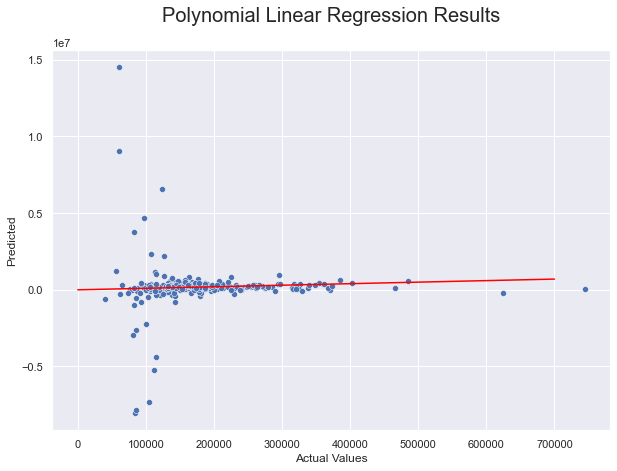

In [60]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 700000], y = [0, 700000],  color = "red")
plt.title("Polynomial Linear Regression Results\n", fontsize = 20)

<font size="+1"> Polynomial Regression is not suited for datasets with such high column count.
I'm actually not sure what happened here, because the number of columns in X_poly can be calculated by :
</font>
<center> features_poly = degree ** features_linear </center>
<font size="+1">
which in this case = 2 ** (200 +) which is basically infinity. <br>
Not even worth finding accuracy metrics.
</font>

In [61]:
X_poly.shape

(1168, 24976)

### 4. Support Vector Regression

In [62]:
# we need to first standardize our data before applying SVR.
# first we'll select columns which are problematic (values are too high)
problematic_cols = [var for var in train.columns if df[var].max() > 3]

In [63]:
from sklearn import preprocessing
train_svr = train.copy()
scx = preprocessing.StandardScaler()
train_svr[problematic_cols] = scx.fit_transform(train_svr[problematic_cols])

In [64]:
y_svr = y.copy().to_numpy()
sc = preprocessing.StandardScaler()
y_svr = sc.fit_transform(y_svr.reshape(len(y_svr), 1))

In [65]:
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(train_svr, y_svr, test_size = 0.2)

<font size="+1"> Training SVR Model </font>

In [66]:
from sklearn.svm import SVR
svr_reg = SVR(kernel='rbf')
svr_reg.fit(X_train_svr, y_train_svr)

SVR()

In [67]:
y_pred_svr = svr_reg.predict(X_test_svr)
y_pred_svr = sc.inverse_transform(y_pred_svr)

In [68]:
y_test_svr = sc.inverse_transform(y_test_svr.flatten())

In [69]:
predict_data = pd.DataFrame({"Actual Values" : list(y_test_svr.flatten()), "Predicted" : list(y_pred_svr)})

In [70]:
predict_data.head(3)

,Actual Values,Predicted
0,180000.0,211235.790376
1,235000.0,199514.457678
2,290000.0,151171.000222


Text(0.5, 1.0, 'SVR Regression Results\n')

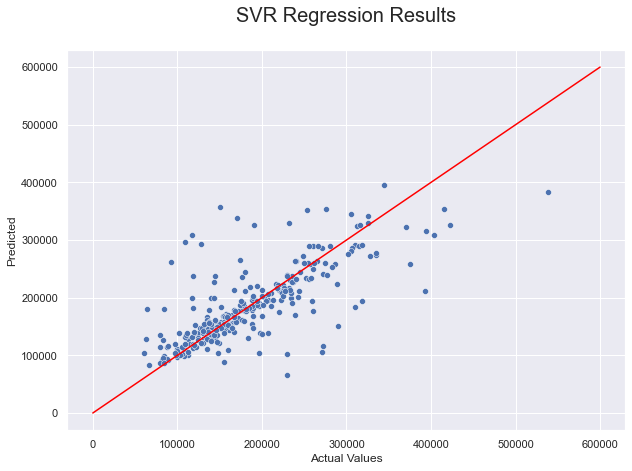

In [71]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 600000], y = [0, 600000],  color = "red")
plt.title("SVR Regression Results\n", fontsize = 20)

In [72]:
model_results.loc[len(model_results)] = [rsquared(y_pred_svr, y_test_svr), adj_rsquared(y_pred_svr, y_test_svr, X_train_svr.shape[1]), math.sqrt(mse(y_pred_svr, y_test_svr)), rmsle(y_pred_svr, y_test_svr), mae(y_pred_svr, y_test_svr)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Support Vector"
model_results.index = indexes
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Support Vector,0.560213,-0.854754,49637.375433,0.265741,29696.727032


<font size="+2"> <i> Basic regression techinques are resulting in large RMSLE and adj. R-squared errors.
Let's move on to ensemble learning. </i></font>
<hr>
<font size="+1"> <b>Conclusion</b> : Best accuracy achieved with Support Vector Regression and Random Forest Regression. </font>

## <u>Advanced Modelling</u>


Let's define cross validation functions as it will be necessary from here on.

In [73]:
# Let's introduce cross-validation.
from sklearn.model_selection import KFold, cross_val_score
def rmse_cv(model, k_fold):
    kf = KFold(k_fold, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

def rmsle_cv(model, k_fold):
    kf = KFold(k_fold, shuffle=True, random_state=42).get_n_splits(train.values)
    rmsle= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_log_error", cv = kf))
    return (rmsle)

<h3> 5. Lasso Regression </h3>

- Lasso Regression is an improvement over Multiple Linear Regression.
- It tried to reduce overfitting and increase generalization.
- The value of alpha determines the level of generalization. At alpha = 0, Lasso Regression behaves exactly like Multiple Linear Regression.

In [74]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

In [75]:
top_score, best_alpha = 1000000000, -1
for i in range(340, 351):
    alpha = 0 + (i * 1)
    lasso_reg = make_pipeline(preprocessing.RobustScaler(), Lasso(alpha = alpha, random_state=0))
    score = rmse_cv(lasso_reg, 15).mean()
    if score < top_score:
        top_score, best_alpha = score, alpha

print("Best Score : {}, with alpha : {}".format(top_score, best_alpha))

Best Score : 50428.09195568132, with alpha : 340


<font size = "+1"> Results are best at alpha = 340. Used Binary Search principle to arrive at this value </font>

In [76]:
lasso_reg = make_pipeline(preprocessing.RobustScaler(), Lasso(alpha=340, random_state=0))

In [77]:
lasso_reg.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=340, random_state=0))])

In [78]:
y_pred = lasso_reg.predict(X_test)

In [79]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Lasso Regression Results\n')

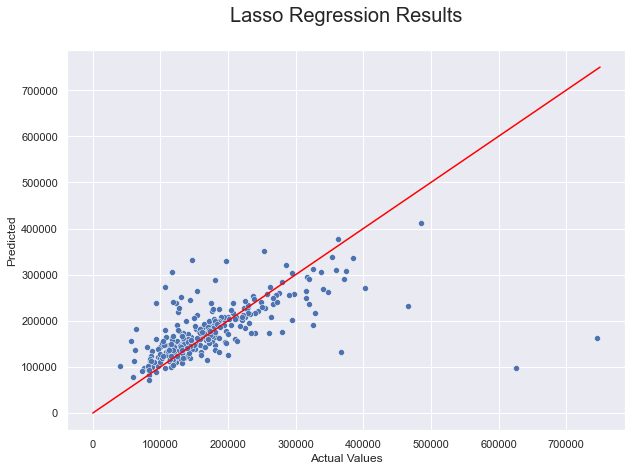

In [80]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("Lasso Regression Results\n", fontsize = 20)

In [81]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Lasso"
model_results.index = indexes
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Lasso,0.379481,-1.616972,66784.078313,0.305752,35466.005101


<font size="+1"> Lasso Regression got a RMSE of 66000 in test dataset. Score has certainly improved over simple MLR </font>

### 6. Elastic-Net Regression
Combines both ridge and lasso regression.

In [82]:
from sklearn.linear_model import ElasticNet
ENet = make_pipeline(preprocessing.RobustScaler(), ElasticNet(alpha=0.4, l1_ratio=.9, random_state=3))
print("Cross-Validation RMSE : {}".format(rmse_cv(ENet, 10).mean()))

Cross-Validation RMSE : 51092.57234862724


In [83]:
ENet.fit(X_train, y_train)
y_pred = ENet.predict(X_test)

Text(0.5, 1.0, 'Elastic Net Regression Results\n')

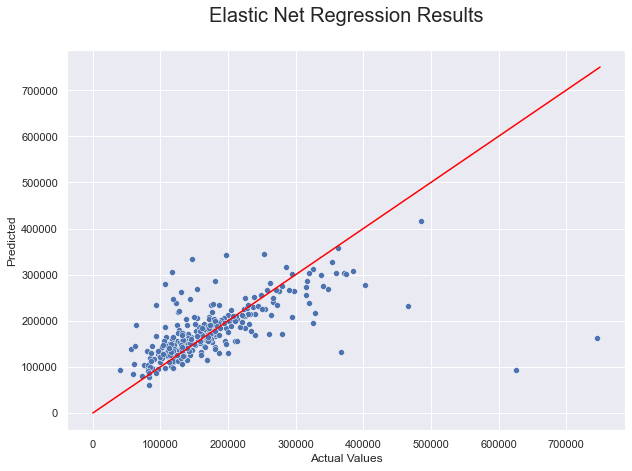

In [84]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("Elastic Net Regression Results\n", fontsize = 20)

In [85]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Elastic Net"
model_results.index = indexes
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Elastic Net,0.373746,-1.641157,67164.455908,0.307575,35623.390148


### 7. Gradient Boost

In [86]:
from sklearn.ensemble import GradientBoostingRegressor
gboost_reg = GradientBoostingRegressor(n_estimators=4000, learning_rate=0.075,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=16, min_samples_split=8,
                                   loss='huber', random_state=0)

In [87]:
print("Gradient Boost RMSE : {}".format(rmse_cv(gboost_reg, 10).mean()))

Gradient Boost RMSE : 54875.523047023686


In [88]:
gboost_reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.075, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=16,
                          min_samples_split=8, n_estimators=4000,
                          random_state=0)

In [89]:
y_pred = gboost_reg.predict(X_test)

Text(0.5, 1.0, 'Gradient Boost Regression Results\n')

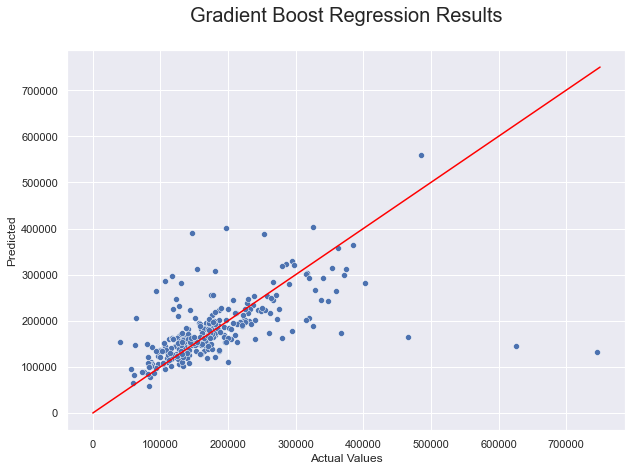

In [90]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("Gradient Boost Regression Results\n", fontsize = 20)

In [91]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Gradient Boost"
model_results.index = indexes
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Gradient Boost,0.344084,-1.766256,70085.961468,0.311859,37203.076406


In [92]:
model_results

,R2,Adj-R2,RMSE,RMSLE,MAE
Random Forest,0.396177,-1.546556,65720.951641,0.305269,35028.155719
Multiple Linear,0.299827,-1.952905,73106.764335,0.378483,41250.383393
Support Vector,0.560213,-0.854754,49637.375433,0.265741,29696.727032
Lasso,0.379481,-1.616972,66784.078313,0.305752,35466.005101
Elastic Net,0.373746,-1.641157,67164.455908,0.307575,35623.390148
Gradient Boost,0.344084,-1.766256,70085.961468,0.311859,37203.076406


### 8. XGBoost Regression

In [101]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()

Text(0.5, 1.0, 'XGBoost Regression Results\n')

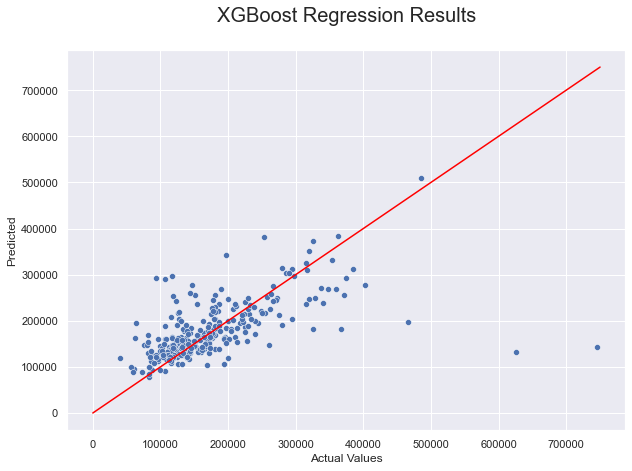

In [103]:
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("XGBoost Regression Results\n", fontsize = 20)

In [104]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "XGBoost"
model_results.index = indexes
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
XGBoost,0.353848,-1.725075,68637.389414,0.318812,38227.194162


## Ensemble Learning
First, let's take a look at all the performance of all the models tested.

In [105]:
model_results

,R2,Adj-R2,RMSE,RMSLE,MAE
Random Forest,0.396177,-1.546556,65720.951641,0.305269,35028.155719
Multiple Linear,0.299827,-1.952905,73106.764335,0.378483,41250.383393
Support Vector,0.560213,-0.854754,49637.375433,0.265741,29696.727032
Lasso,0.379481,-1.616972,66784.078313,0.305752,35466.005101
Elastic Net,0.373746,-1.641157,67164.455908,0.307575,35623.390148
Gradient Boost,0.344084,-1.766256,70085.961468,0.311859,37203.076406
XGBoost,0.353848,-1.725075,68637.389414,0.318812,38227.194162


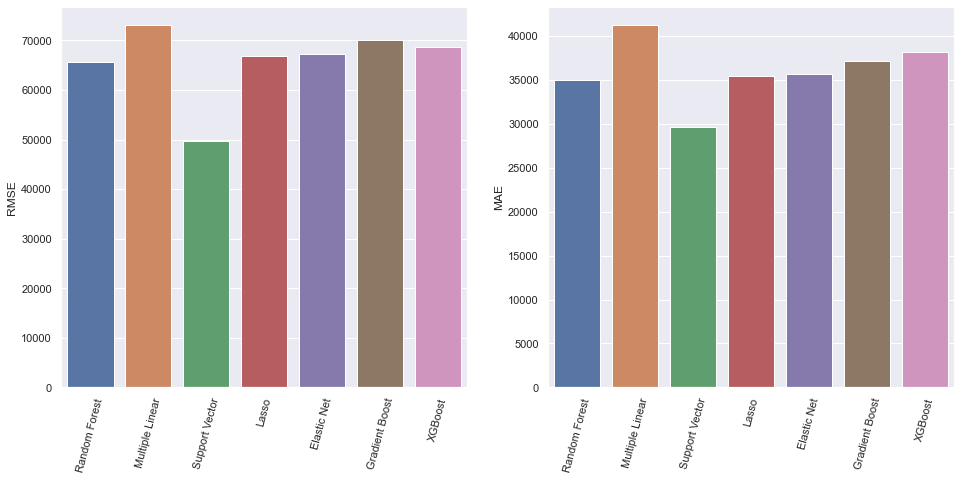

In [121]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
rmseplot = sns.barplot(y = model_results["RMSE"], x =  model_results.index)
plt.xticks(rotation = 75)
plt.subplot(1, 2, 2)
maeplot = sns.barplot(y = model_results["MAE"], x =  model_results.index)
plt.xticks(rotation = 75)
plt.show()

Top 3 models are Support Vector Regression, Random Forest, and Lasso Regression.

### Bagging Approach
Returns mean prediction of all given models.

In [122]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [123]:
svr_reg = make_pipeline(preprocessing.StandardScaler(), SVR(kernel='rbf'))
xgb_reg = xgb.XGBRegressor()
lasso_reg = make_pipeline(preprocessing.RobustScaler(), Lasso(alpha=340, random_state=0))
rfr_reg = RandomForestRegressor(n_estimators = 500, random_state = 0)

bagged_model = AveragingModels(models = (svr_reg, xgb_reg, lasso_reg, rfr_reg))

In [124]:
bagged_model.fit(X_train, y_train)
y_pred = bagged_model.predict(X_test)

Text(0.5, 1.0, 'Bagged Model Regression Results\n')

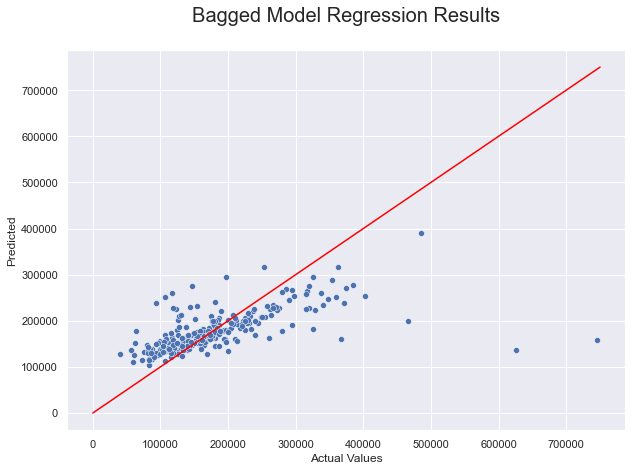

In [126]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("Bagged Model Regression Results\n", fontsize = 20)

In [127]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Average Ensemble"
model_results.index = indexes
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Average Ensemble,0.394607,-1.553179,66665.076146,0.311787,38105.629979


<hr>
<h3> SVR still remains unbeaten. <h3>
<hr>